#### Student Name: Neta Nakdimon
#### Student ID: 322216128

# Overview
### Due Dec 14th

##Instructions:

This notebook is an interactive assignment; please read and follow the instructions in each cell.

Assignments are to be turned in individually, you can collaborate with one classmate but EACH must turn in a copy of the homework.

Cells that require your input (in the form of code or written response) will have 'Question #' above.

After completing the assignment, please submit this notebook. Please leave the audio loaded when submitting the homework.

YOU MUST SUBMIT EACH HOMEWORK, even if your partner submits! Upload your completed assignment on moodle.

In [1]:
# If you're collaboraing with a classmate, please fill in the following:

collaboration = {
    "322216128" : "319046611"
}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
from numpy.linalg import svd
from scipy.stats.mstats import gmean
from matplotlib import rcParams
import scipy
import os
import sys
import glob
import pickle
from music21 import converter, instrument, note, chord, stream
import torch
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.disable_v2_behavior()



Instructions for updating:
non-resource variables are not supported in the long term


# PCA with a Linear Autoencoder


In this problem, we will practice using basic neural network procedures by running an autoencoder network.
This network is implemented in TensorFlow (essentially Keras with an expanded toolset); the functions we call are nearly identical to those you will see in Keras.

Let's create a sin+noise signal to use as input to our network:

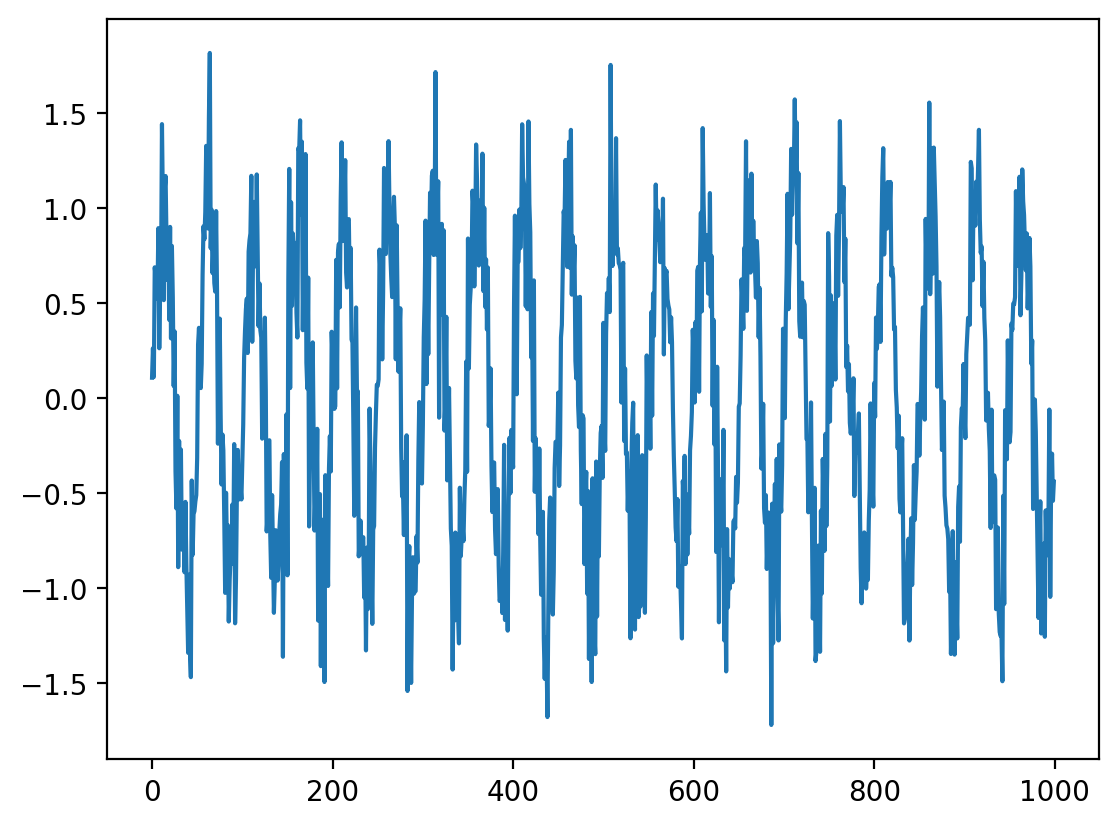

In [3]:
f0 = 200
fs = 10000
T = 3
Ns = fs*T

def buffer(input_data, sample_rate, window_size, hop_size):
    output = np.array([input_data[i:i+window_size] for i in range(0, len(input_data)-window_size, hop_size)])
    return output.T

s = np.sin(2*np.pi*f0*np.arange(Ns)/fs)

n = np.random.randn(Ns)

x = s + 0.3*n

plt.plot(x[:1000])
wavfile.write('out2.wav', fs, x)
xmat = buffer(x,fs,400,200)

Here we create an AE with 2 hidden layers.

This neural network is implemented in TensorFlow.

Please review the code cells below, and answer the questions that follow.

In [4]:
# Initialize parameters
n_inputs = xmat.shape[0]
n_hidden = 2
learning_rate = 0.01
n_iterations = 10000

# Convert data to PyTorch tensors
X_train = torch.tensor(xmat.T, dtype=torch.float32)
X_test = X_train.clone()

# Initialize weights
W = torch.empty(n_inputs, n_hidden, dtype=torch.float32, requires_grad=True)
torch.nn.init.trunc_normal_(W, std=0.1)

# Training loop
optimizer = torch.optim.Adam([W], lr=learning_rate)
init = tf.global_variables_initializer()


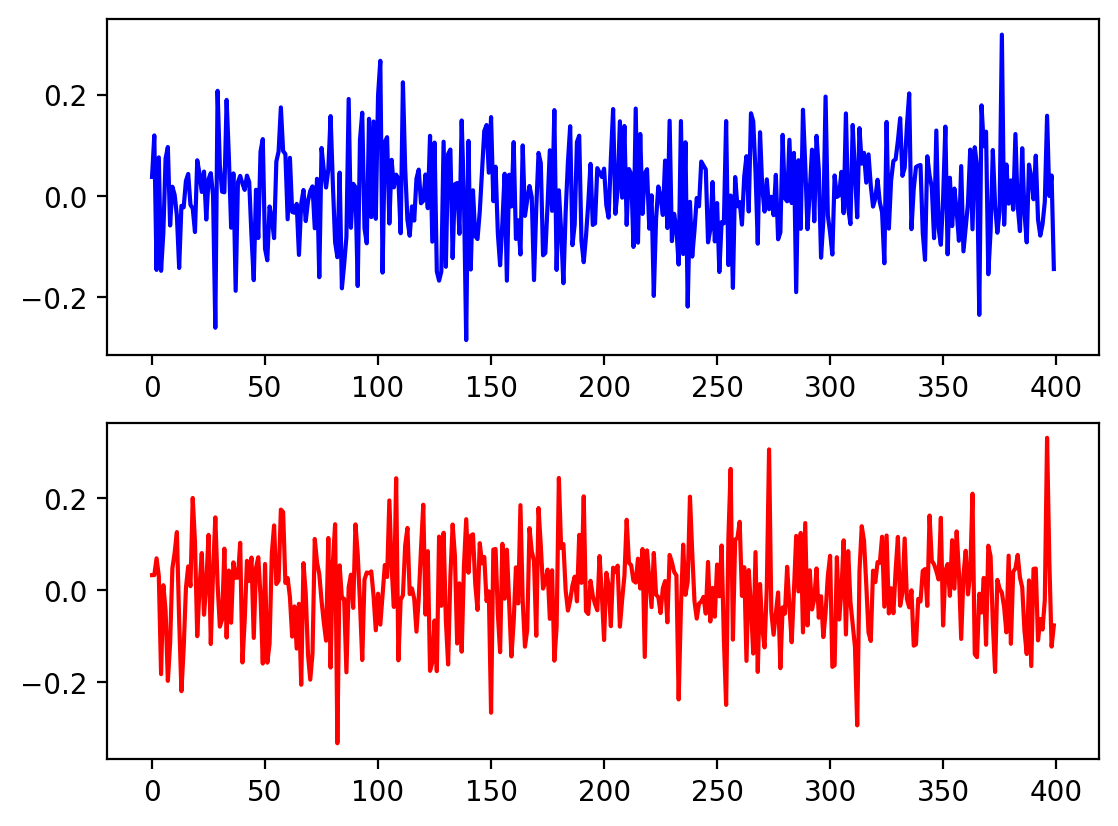

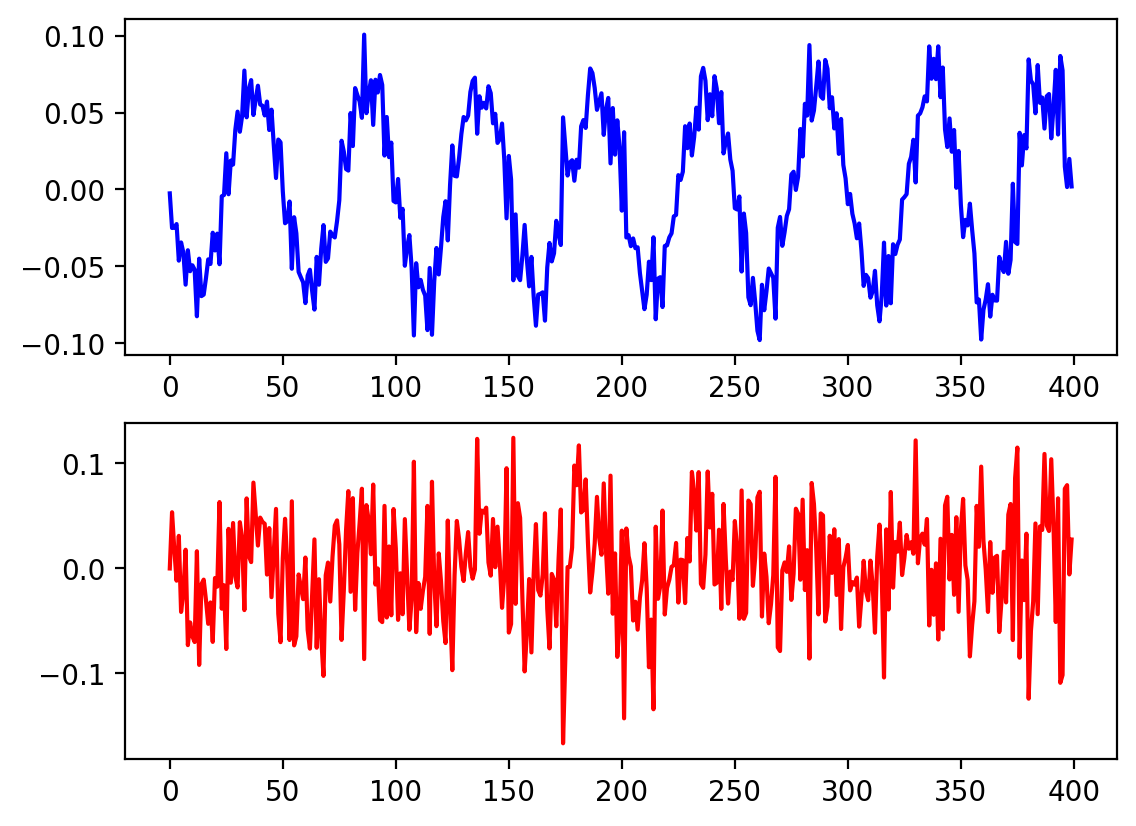

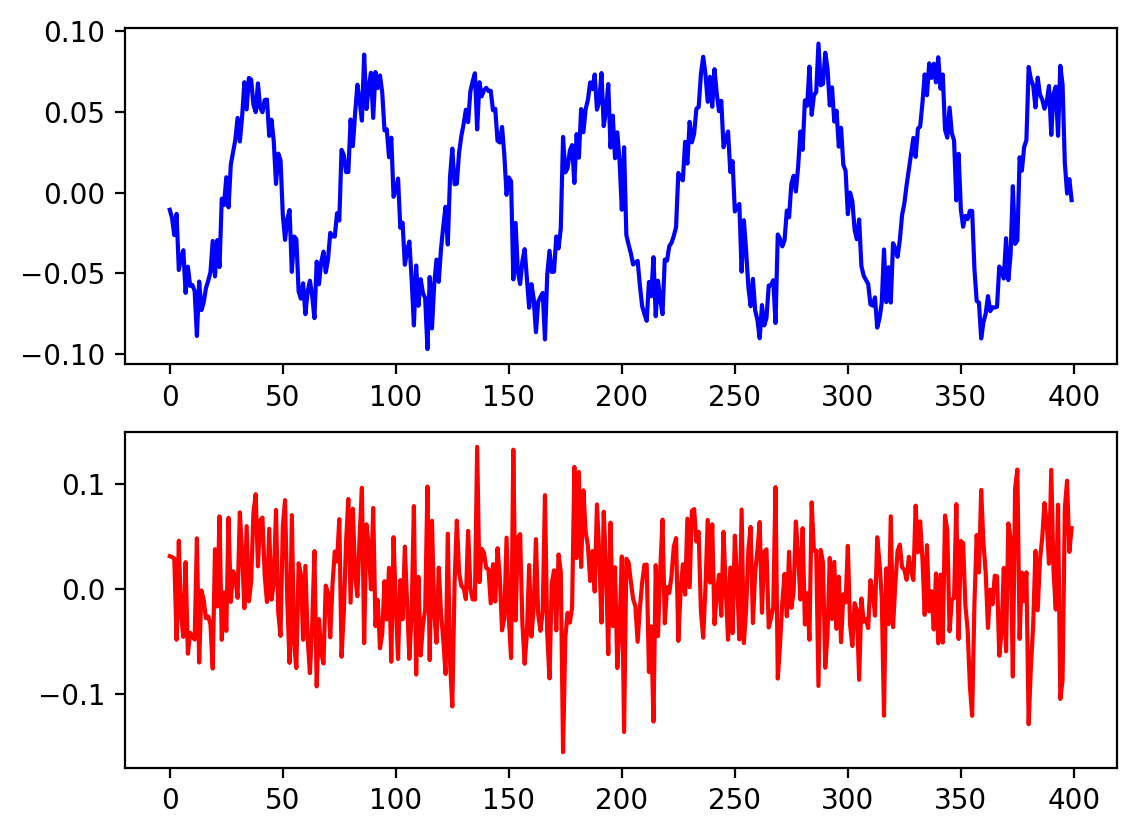

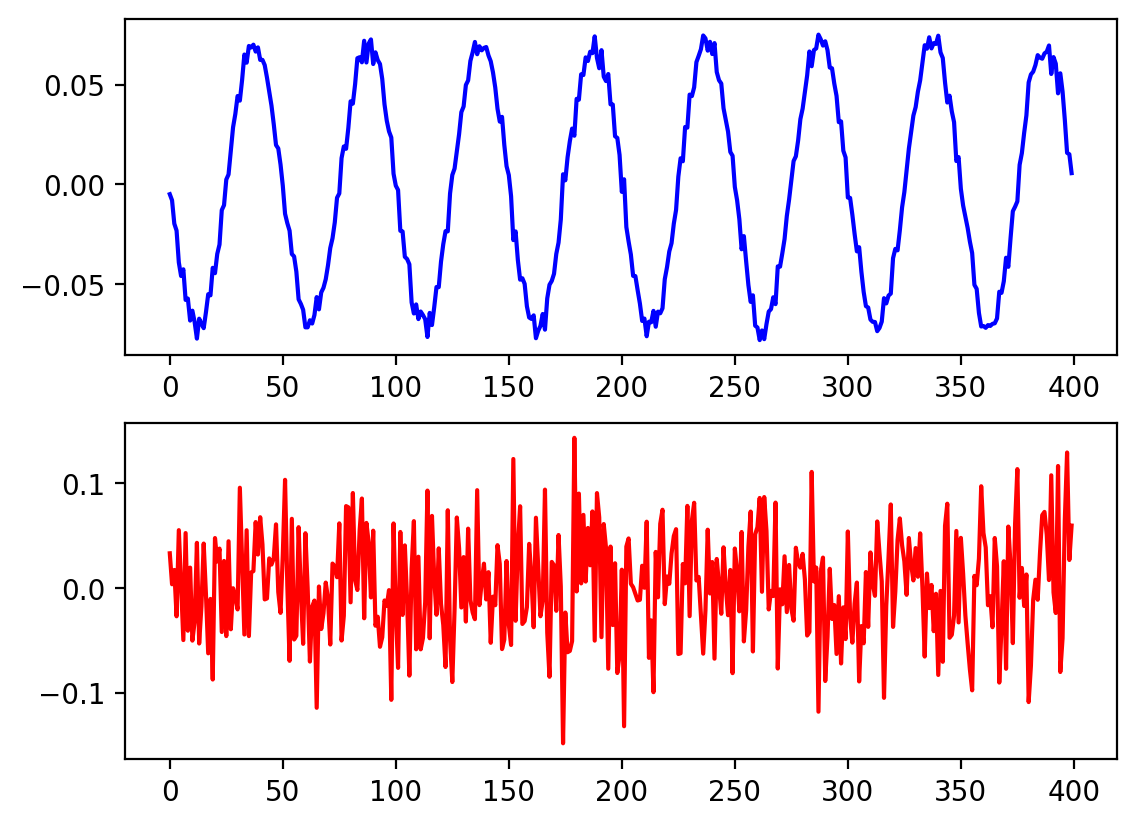

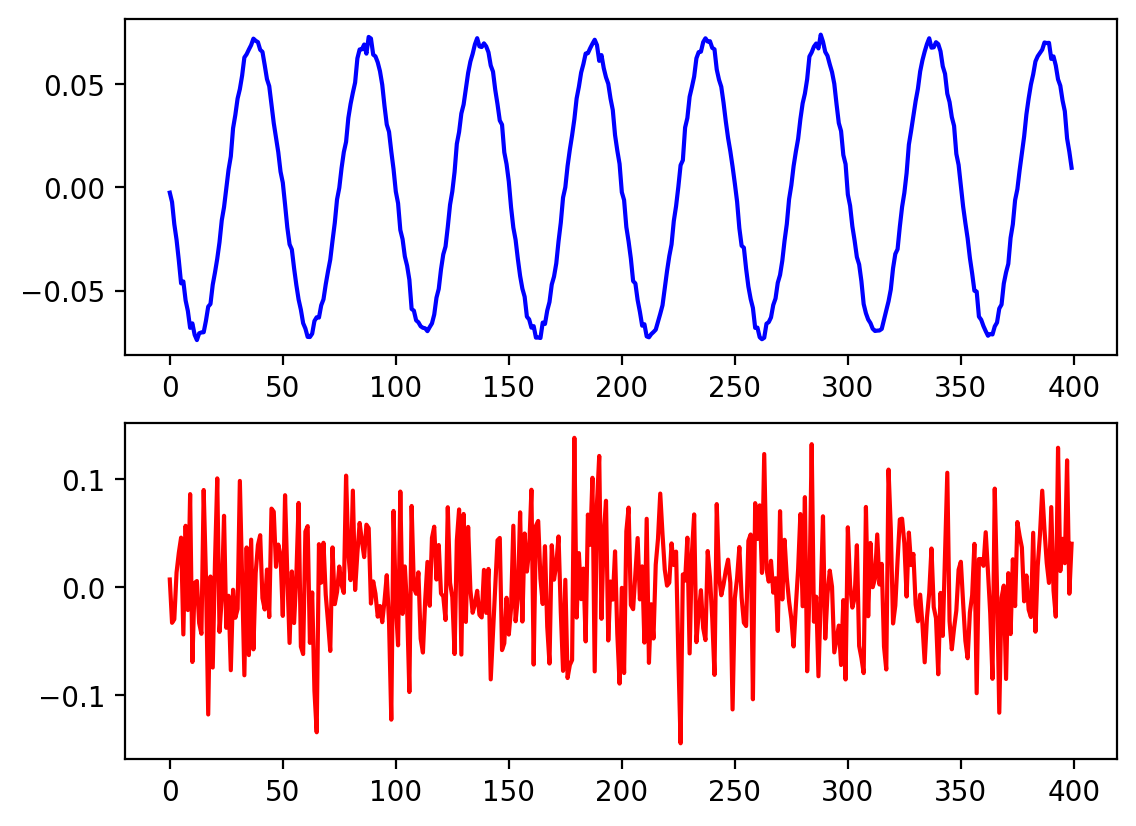

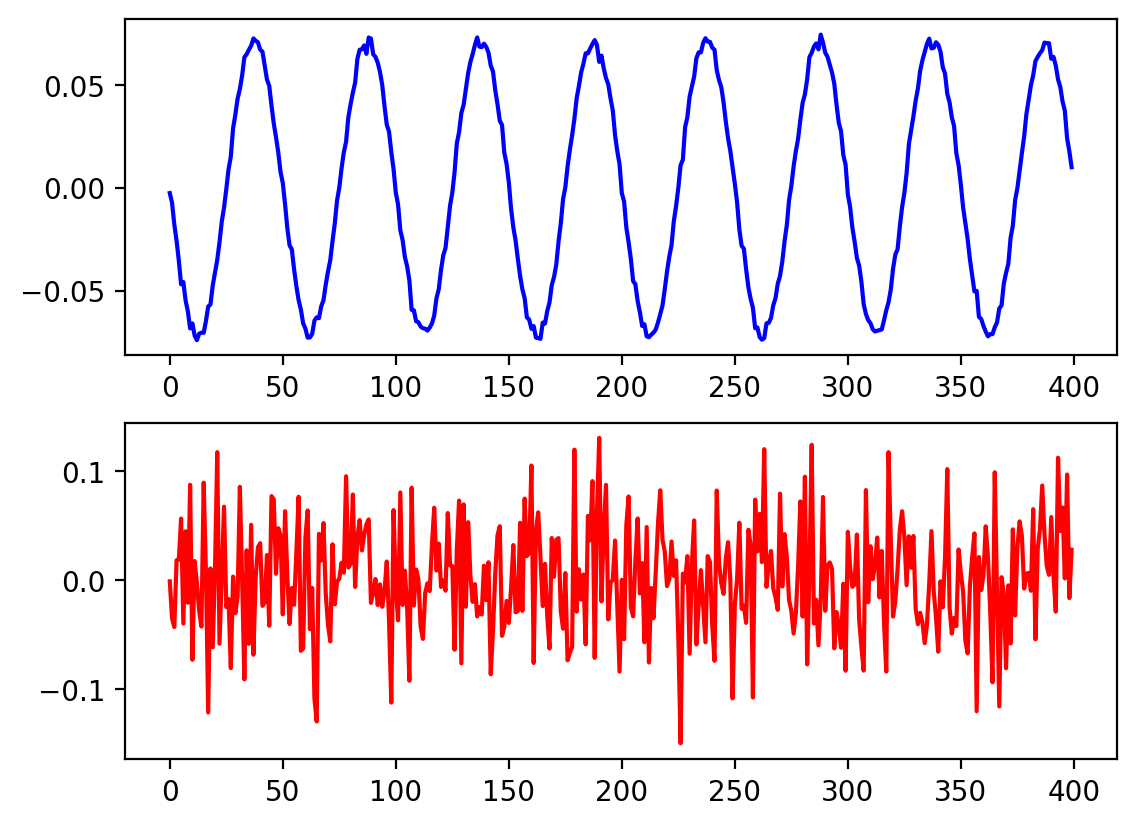

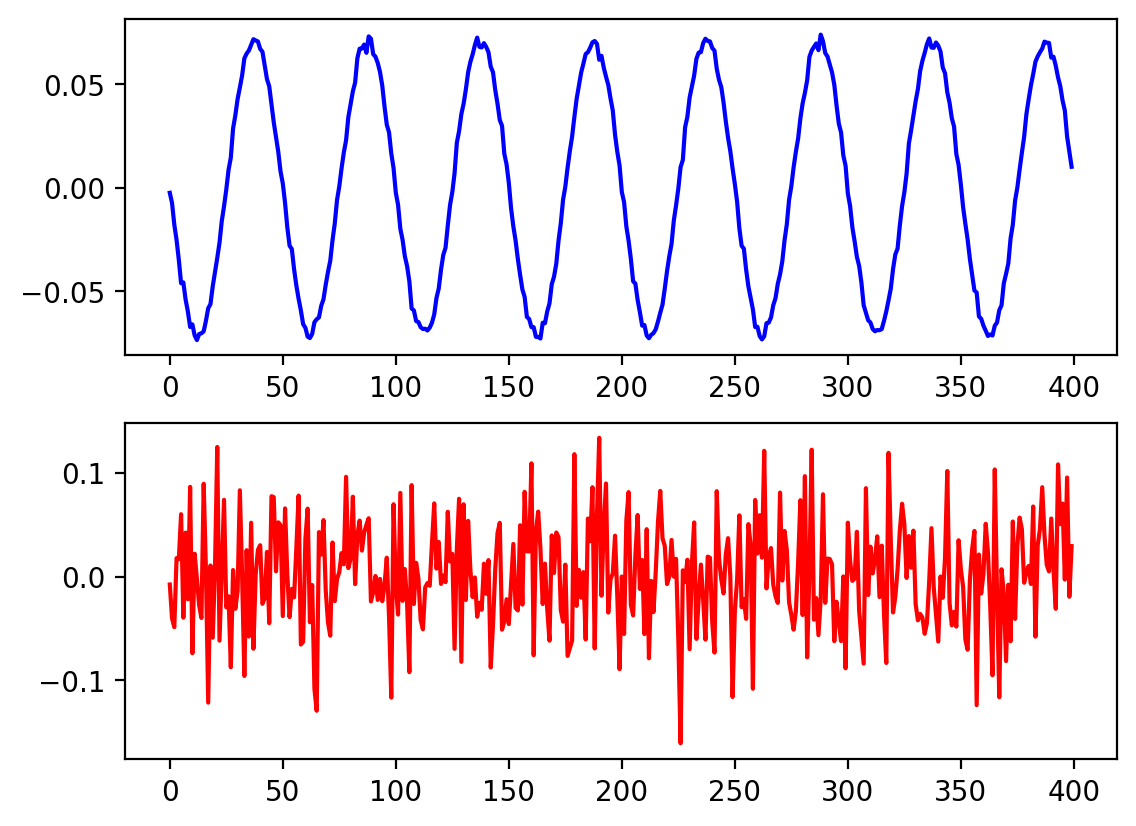

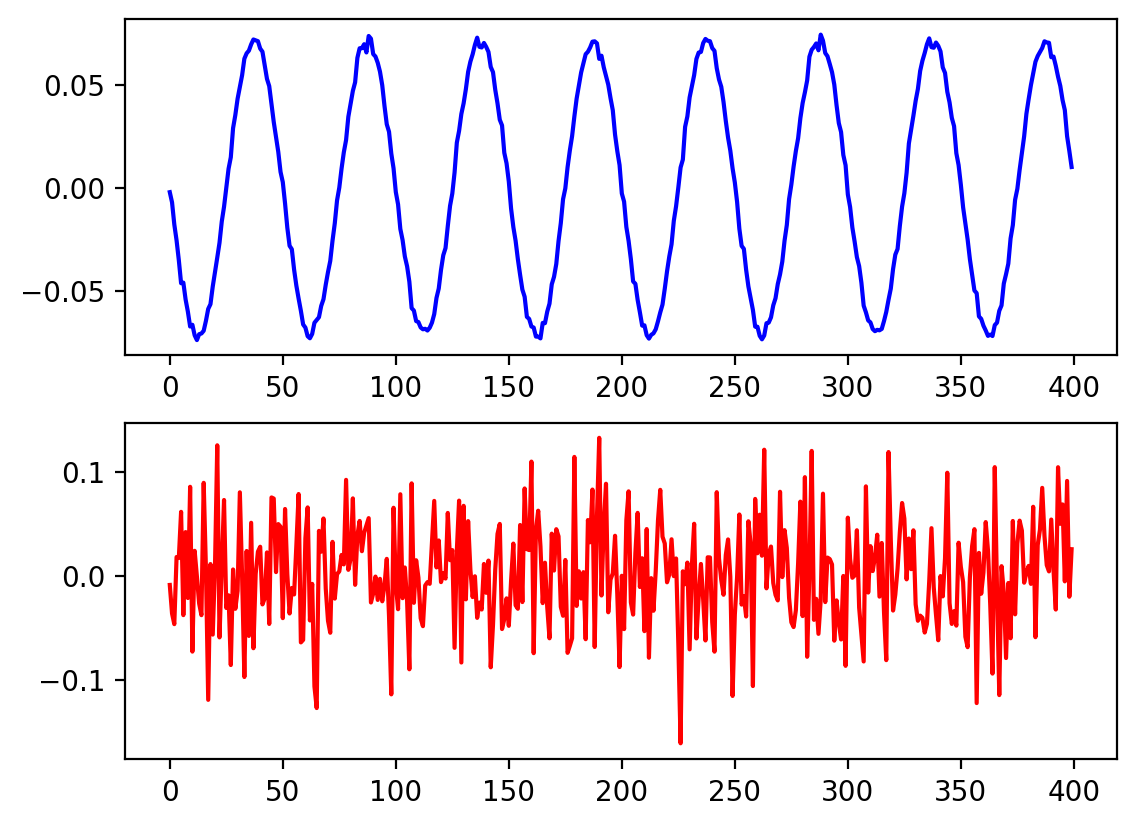

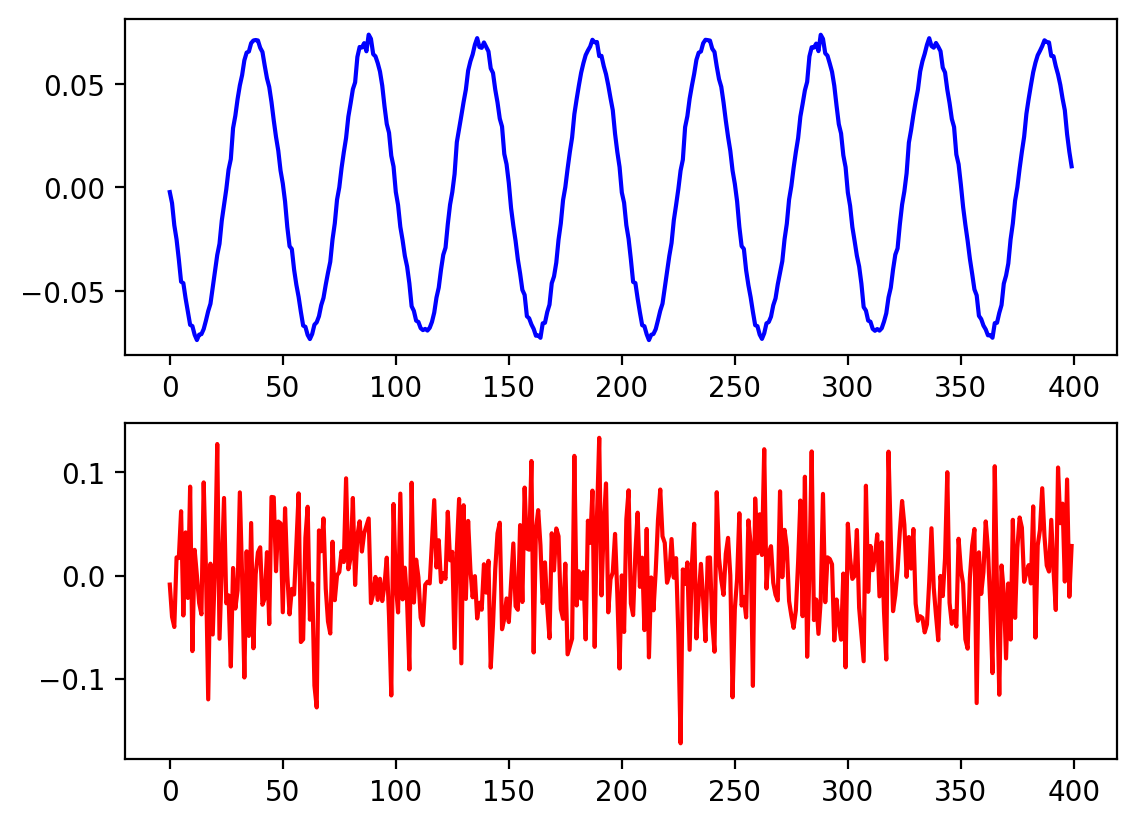

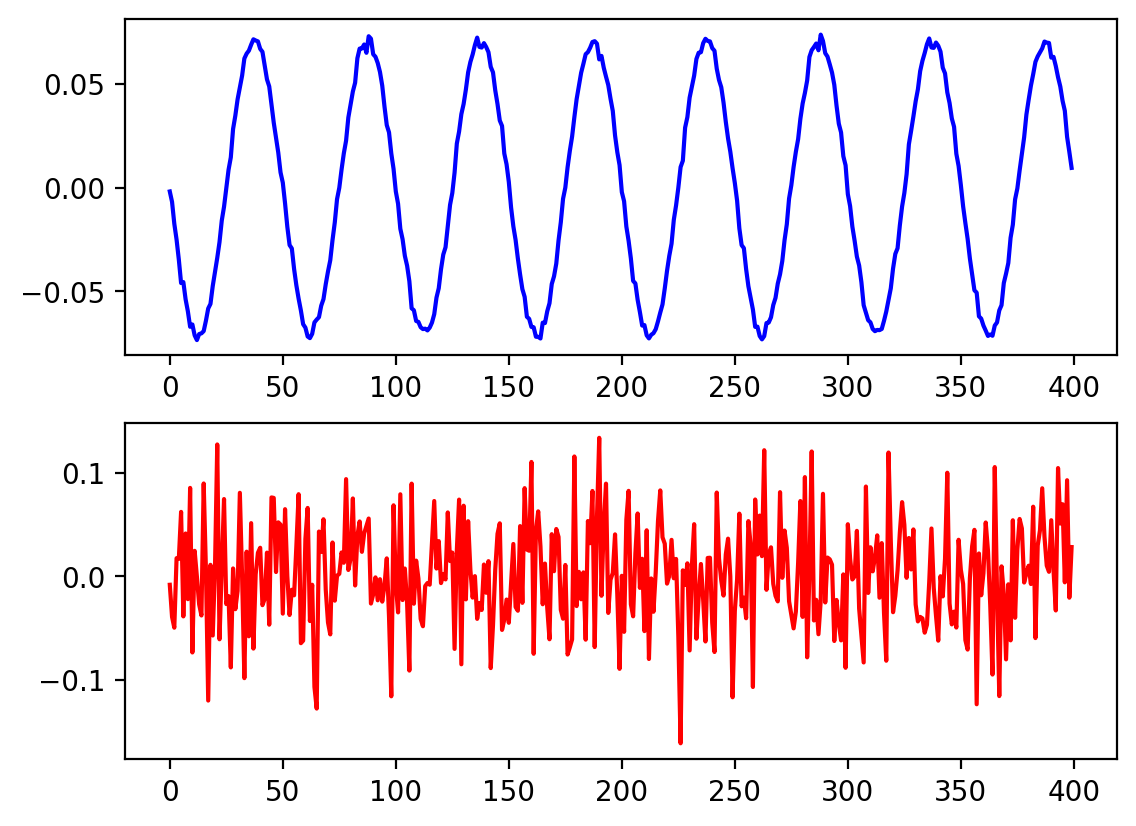

Done with training


In [5]:
col = ['b', 'r', 'g', 'c', 'm', 'y', 'k']

for iteration in range(n_iterations):
    # Forward pass
    hidden = torch.matmul(X_train, W)
    outputs = torch.matmul(hidden, W.T)
    reconstruction_loss = torch.mean((outputs - X_train) ** 2)

    # Backward pass
    optimizer.zero_grad()
    reconstruction_loss.backward()
    optimizer.step()

    # Visualization every 1000 iterations
    if iteration % 1000 == 0:
        with torch.no_grad():
            W_val = W.detach().numpy()
        plt.clf()
        for k in range(n_hidden):
            plt.subplot(n_hidden, 1, k + 1)
            plt.plot(W_val[:, k], col[k % len(col)])
        plt.show(block=False)
        plt.pause(0.001)

# Get codings
with torch.no_grad():
    codings_val = torch.matmul(X_test, W).numpy()

print("Done with training")


##### Question 1 (10 points)

What is an autoencoder? Please explain briefly. What would happen (ideally) if you pass a portion of signal x through the trained network?

An autoencoder is a specialized type of neural network widely used in signal processing to learn efficient data representations. It comprises two main components: the encoder, which compresses the input signal into a lower-dimensional latent space, and the decoder, which reconstructs the original signal from this compressed representation. Key capabilities of an autoencoder include dimensionality reduction, noise removal, and unsupervised learning.

When a segment of a signal, x, is passed through a trained autoencoder, the encoding phase compresses the segment into its latent representation, capturing essential features. During the decoding phase, the autoencoder reconstructs the input from this compressed form. Ideally, the output closely matches the original input, preserving its key characteristics. Additionally, the autoencoder may produce a denoised version of the signal if noise is present in the input. However, if the input significantly differs from the training data, the reconstruction quality may degrade.
Thus, a trained autoencoder reconstructs signal portions effectively, assuming they align with the training data distribution.

##### Question 2 (10 points)

Based on the observed shape of n_inputs and the definition of X_train, what exactly is being passed to the input layer of the network for a single forward pass? Be specific!

In [6]:
n_inputs

400

In [7]:
X_train.shape

torch.Size([148, 400])

The value of n_inputs, which is derived from the number of rows in xmat (400), indicates the number of features or dimensions in each data sample, corresponding to the window size of the original sinusoidal signal with added noise. The dataset X_train is defined as the transpose of xmat and has a shape of (148, 400), where each row represents a single data sample and each column corresponds to a feature or time step in the signal. During training, the entire dataset is passed to the network in a single forward pass (training_op.run(feed_dict={X: X_train})), effectively using a batch size of 148. Each row of X_train contains 400 features, representing the overlapping windows of the signal. The encoder compresses these 400-dimensional inputs into 2-dimensional latent representations, which are then reconstructed by the decoder back into 400-dimensional vectors to recover the original signal windows.

##### Question 3 (10 points)

What variable(s) are used to represent the network weights? How are these weights initialized prior to training?

The network weights are represented by the variable W, which is initialized in the code with the line: W = tf.Variable(tf.truncated_normal(stddev=0.1, shape=[n_inputs, n_hidden])).

The weight matrix W has dimensions determined by n_inputs (the number of input features, 400 in our case) and n_hidden (the number of neurons in the hidden layer, 2 here). During the decoding step, the transpose of W (W.T, with shape [2, 400]) is used to map the 2 hidden layers and space back to the original 400-dimensional input space.

Weights are initialized using a truncated normal distribution, which generates random values from a normal distribution but excludes outliers beyond a certain range. This ensures that all weights are kept within a reasonable range, avoiding extremes that could destabilize training. The initialization uses a mean of 0 and a standard deviation of 0.1, producing a narrow distribution of initial values. This approach helps ensure that the weights are small at the start of training, promoting smoother learning. The weights are initialized when the TensorFlow session executes init.run(). During training, these weights are adjusted iteratively to minimize reconstruction loss and improve the network’s ability to encode and decode the data effectively.

##### Question  4 (10 points)

What is being minimized in the reconstruction loss? Why is this helpful?

The reconstruction loss, defined as reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)), computes the mean squared error (MSE) between the reconstructed output (outputs) and the original input (X). During training, this loss is minimized to improve the autoencoder's performance. It quantifies how accurately the decoder reproduces the input data, with the goal being to reduce the difference between the original signal and its reconstruction as much as possible.

Minimizing this loss is crucial because it allows the autoencoder to capture and encode the most significant features of the data. By learning to preserve the essential structure of the input, the autoencoder becomes effective at representing the data efficiently. Additionally, autoencoders are particularly useful for denoising tasks. When trained on noisy input signals, minimizing the reconstruction loss enables the network to focus on the underlying patterns while filtering out noise, making it a powerful tool for signal preprocessing and noise reduction.

##### Question 5 (10 points)

What is an optimizer? What are 3 common optimizers? Which optimizer is used in this AE training?

An optimizer is a method used to adjust a neural network's weights and biases to minimize an objective function, often the loss function, which measures the error between the network's predictions and the actual data. Optimizers play a key role in training by guiding how parameters are updated to improve the network’s performance.

The main purpose of an optimizer is to find the set of weights that minimize the loss function, resulting in better predictions. This involves calculating the gradient of the loss function with respect to the weights, which determines the direction and magnitude of updates. The optimizer uses this information to iteratively adjust the parameters, often with the help of backpropagation to propagate error gradients through the network.

1. Common Optimizers:
Stochastic Gradient Descent (SGD): Updates weights based on small batches of data, which introduces randomness. This helps escape local minima but can lead to unstable or slow convergence due to variance in updates. It uses a fixed learning rate for all steps unless modified with momentum or scheduling.

2. RMSprop: Adapts the learning rate for each parameter based on the average of recent squared gradients. This helps stabilize and speed up convergence, especially in problems with noisy gradients. RMSprop adjusts step sizes dynamically, making it well-suited for tasks with varying gradient magnitudes.

3. Adam (Adaptive Moment Estimation): Combines ideas from RMSprop and momentum. It adapts learning rates for individual parameters while keeping moving averages of both gradients and squared gradients. Adam is efficient, requires little tuning, and is widely used for its ability to converge quickly and handle sparse or noisy gradients.

In this AE training the optimizer used it the Adam optimizer, as can be seen in this line:
optimizer = tf.train.AdamOptimizer(learning_rate)

We can examine now the "codings", i.e. the hidden unit values and their distribution. The more significant codings should have smaller variances.

mean:  [-14.13143     -0.11645571]
variance [0.3114315 0.7741171]


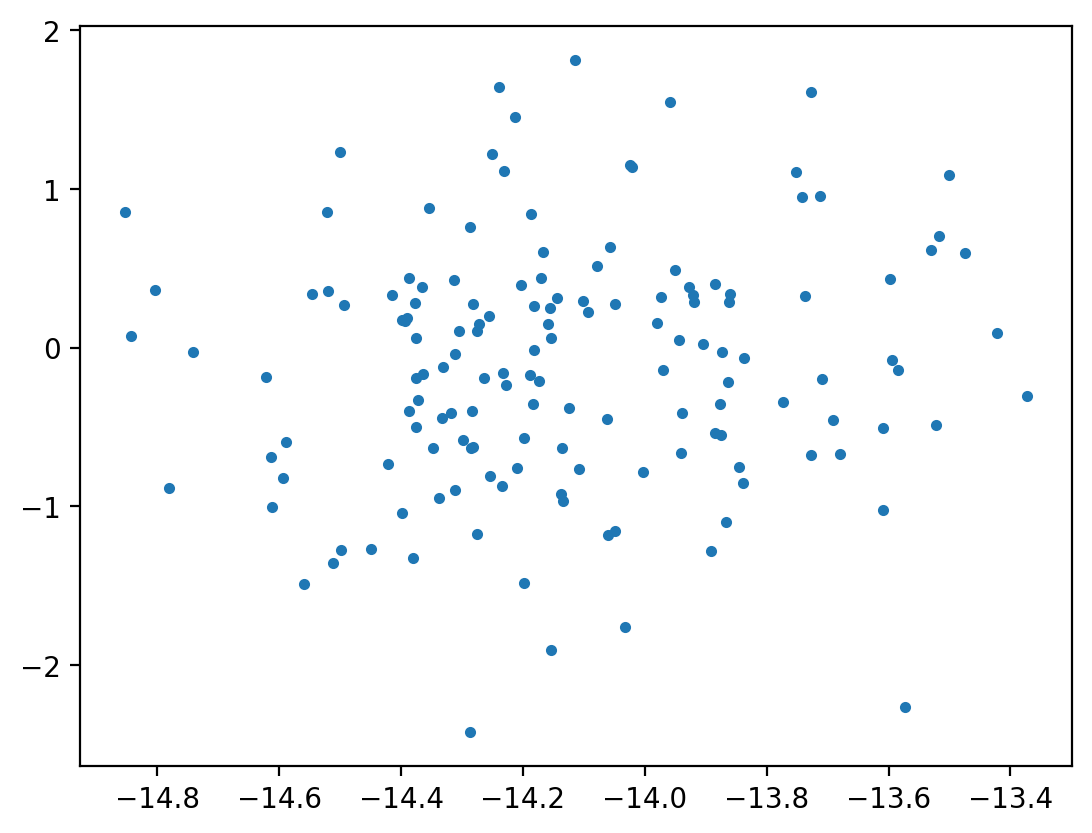

In [8]:
plt.plot(codings_val[:,0],codings_val[:,1],'.')
print ("mean: ", np.mean(codings_val,0))
print ("variance", np.std(codings_val,0))

###### Question 6 (10 points)

In what way does the autoencoder network function similarly to PCA?

1. Dimensionality Reduction: Both reduce data to a lower-dimensional representation.

2. Reconstruction: Both aim to reconstruct the original input from the reduced representation.

3. Minimizing Reconstruction Error: PCA minimizes variance loss, while autoencoders minimize reconstruction loss (MSE).

4. Linear: PCA uses linear transformations to find orthogonal components that capture maximum variance. Autoencoders, with linear activation functions, can mimic this by learning similar linear transformations to reduce dimensionality.

5. Feature Extraction: Both extract key features, but PCA uses variance, while autoencoders learn features through optimization.Autoencoders extend PCA’s functionality by handling complex, non-linear data.

##### Question 7 - PCA versus AE (20 points)

Using sklearn.decomposition.PCA (or another PCA implementation in Python), illustrate the ideas you discuss in Question 1 & Question 7. You should have two plots: one showing the output of the AE network on a single sample, and another showing the output of your PCA on the same sample. How many principal components do you use in your reconstruction to achieve similar performance to the AE network?


In [19]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

def performPCA(n_components):

    pca = PCA(n_components=n_components)
    pca.fit(X_train.numpy())
    pca_transform = pca.transform(X_train.numpy())
    explained_variance = pca.explained_variance_ratio_
    
    print("Explained Variance: ", explained_variance)
    print(f"Number of Components: {n_components}")
    
    pca_output = pca.inverse_transform(pca_transform)

    W_val = W.detach().numpy()  
    hidden = np.dot(X_train.numpy(), W_val)  
    ae_output = np.dot(hidden, W_val.T) 

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(ae_output[0, :200], color='purple', label='AE Output')
    plt.plot(X_test[0, :200], color='pink', linewidth=1, label='X_test')
    plt.title('Autoencoder Output vs X_test')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(pca_output[0, :200], color='pink', label='PCA Output')
    plt.plot(X_test[0, :200], color='purple', linewidth=1, label='X_test')
    plt.title('PCA Output vs X_test')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(pca_output[0, :200], color='pink', linewidth=1, label="PCA Output")
    plt.plot(ae_output[0, :200], color='purple', linewidth=1, label="AE Output")
    plt.legend()
    plt.title("PCA vs AE Output Comparison")

    plt.tight_layout()
    plt.show()


Explained Variance:  [0.01694589]
Number of Components: 1


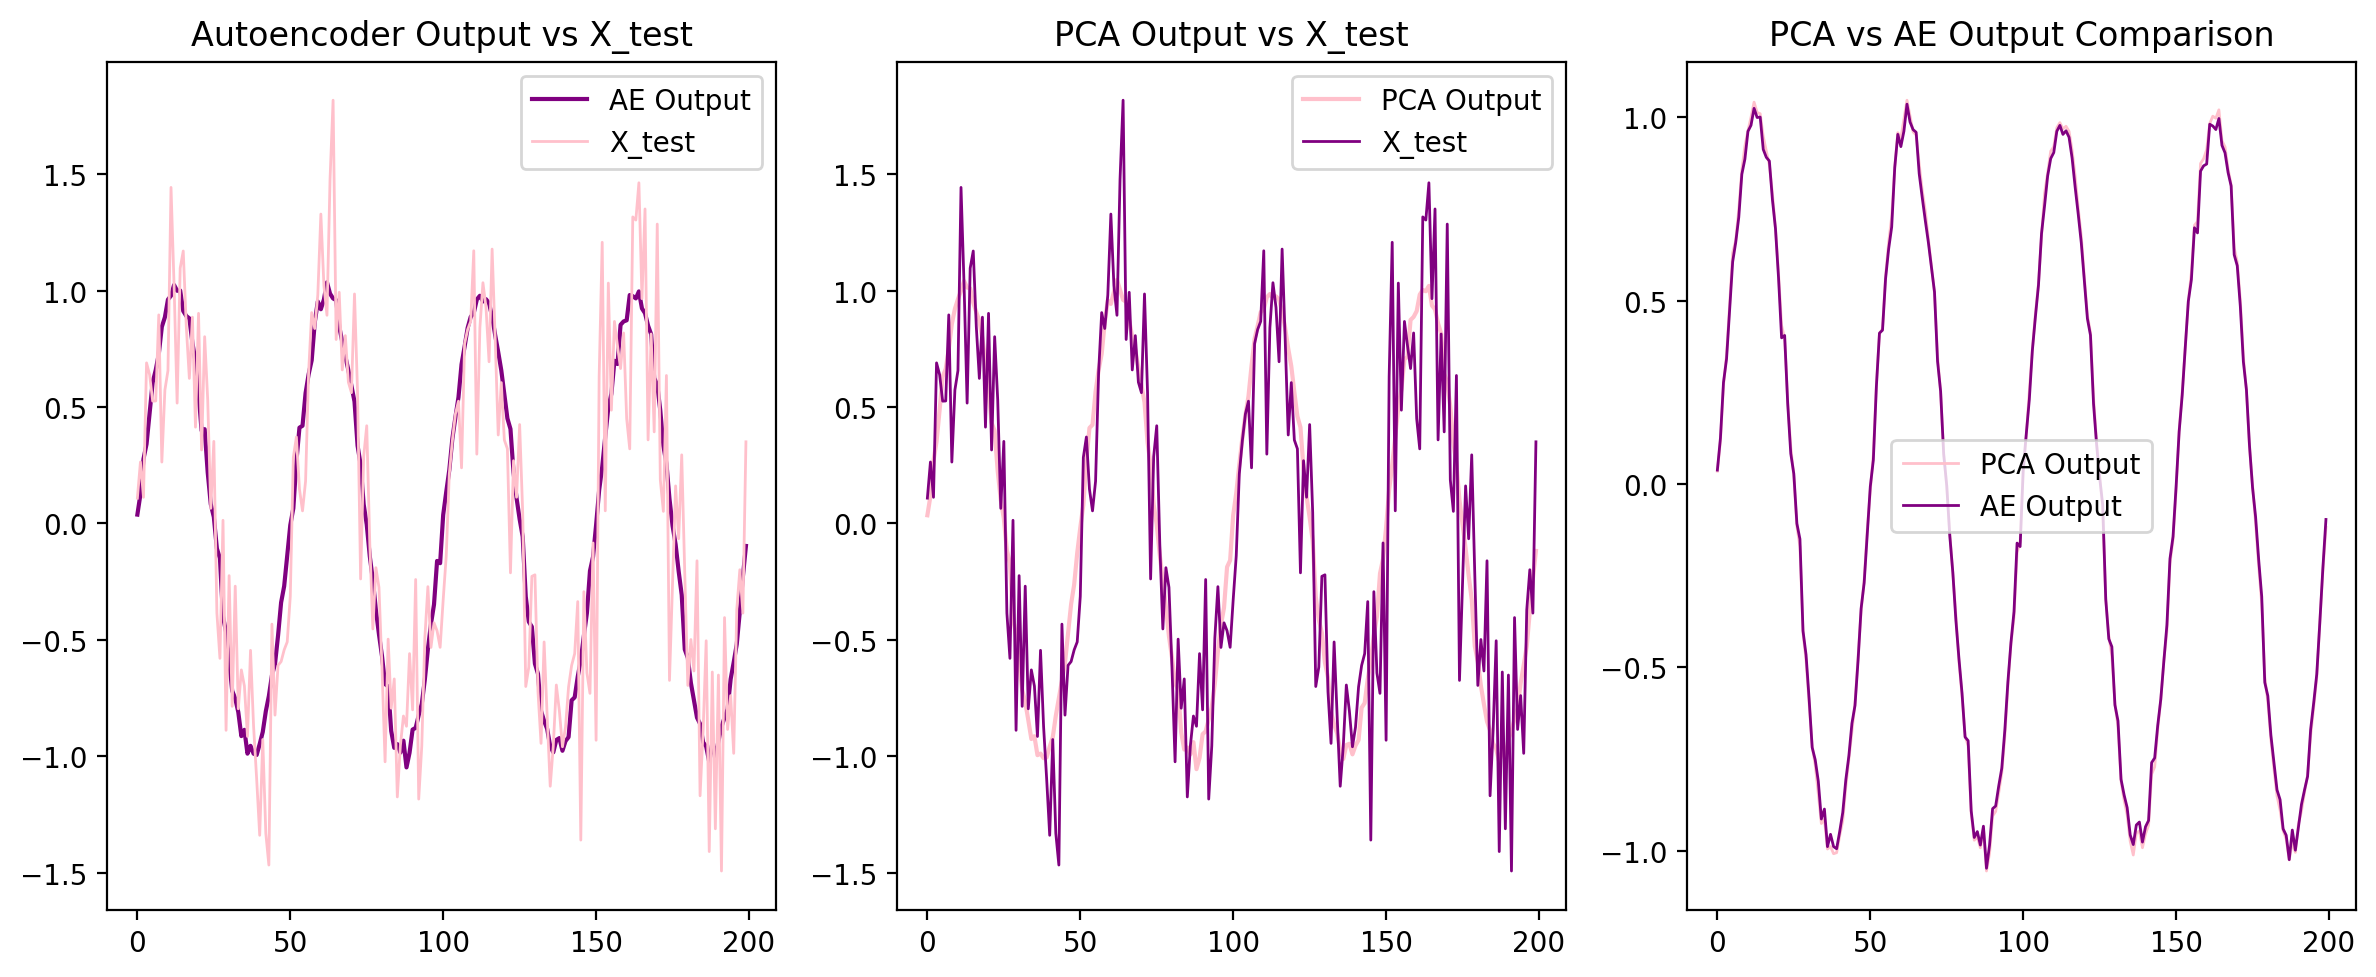

In [20]:
performPCA(1)

Explained Variance:  [0.01694589 0.01669741]
Number of Components: 2


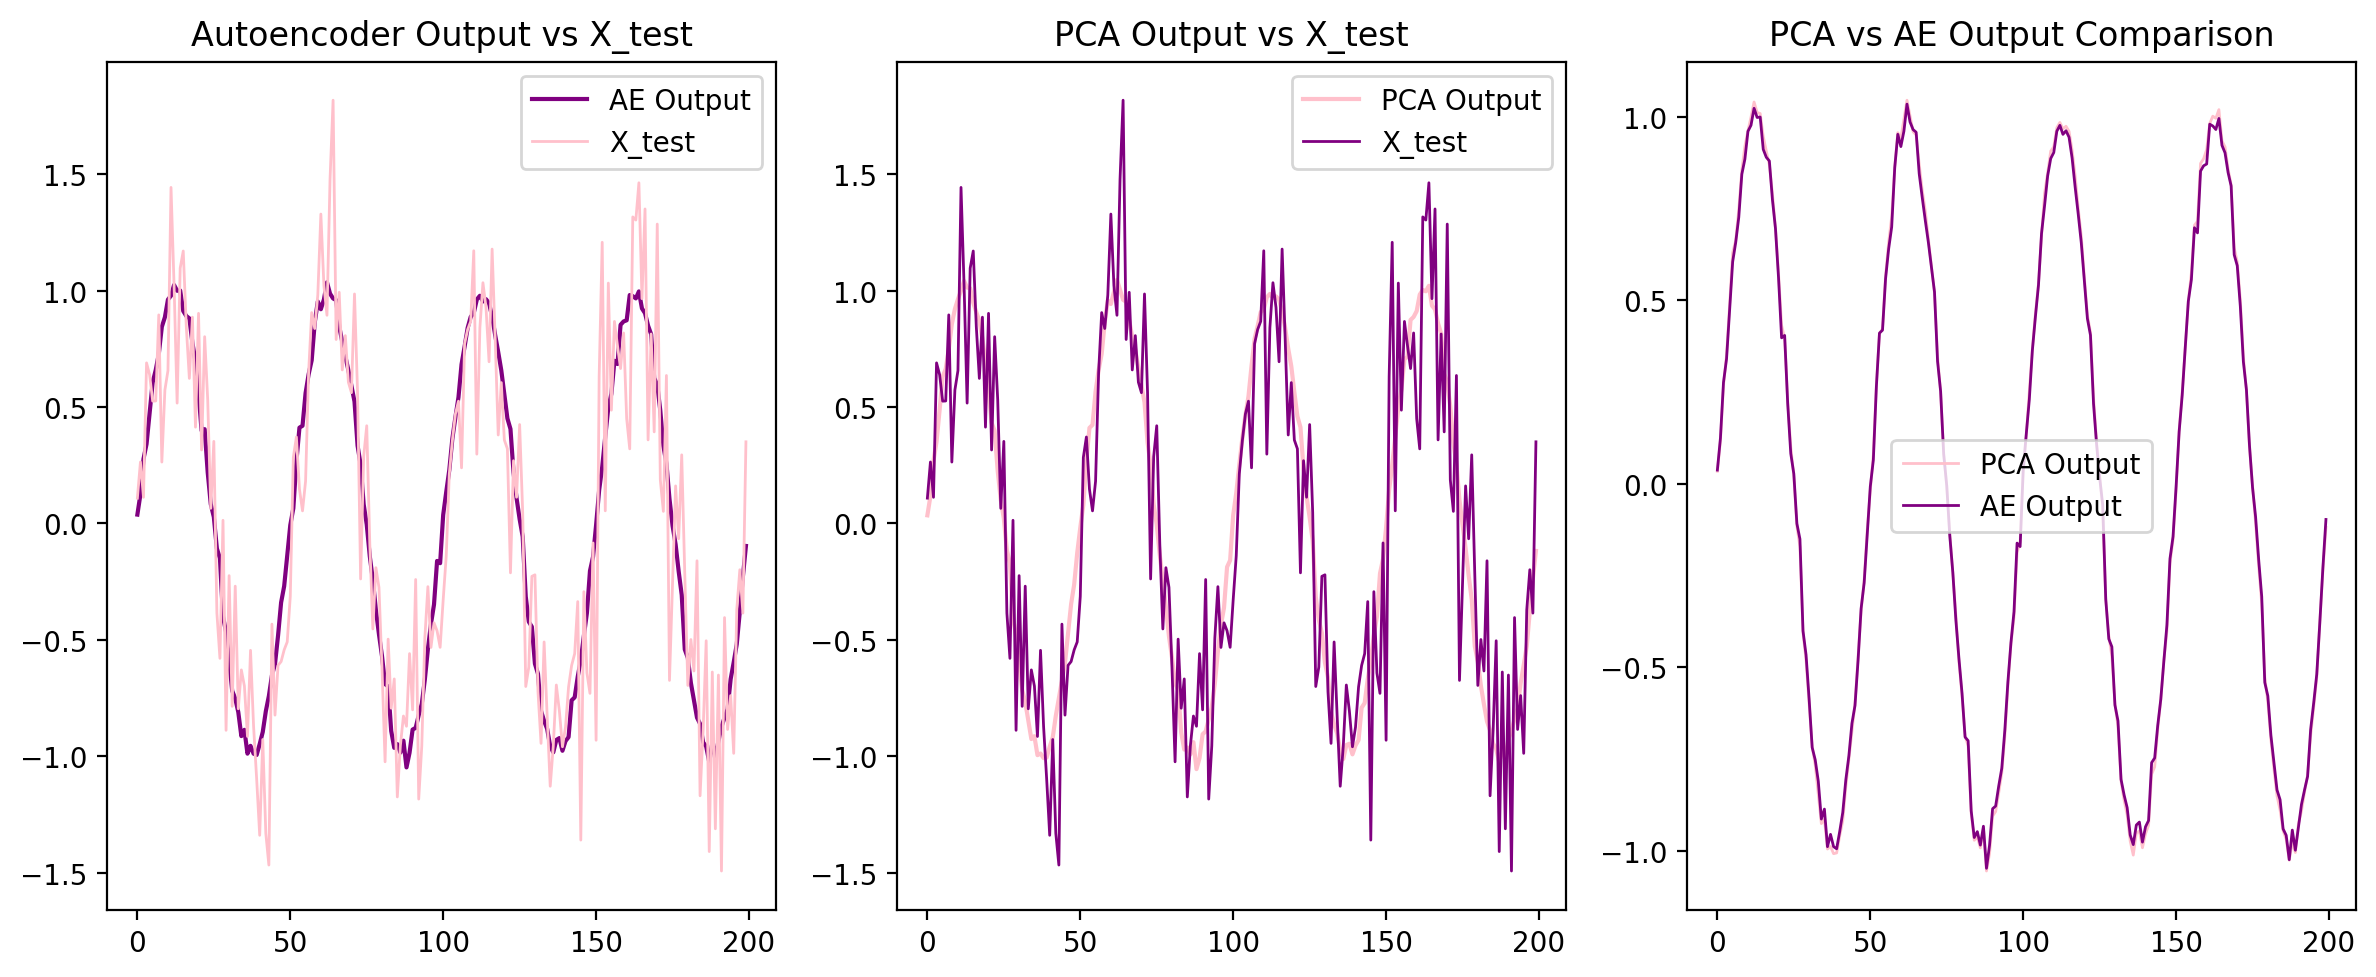

In [21]:
performPCA(2)

Explained Variance:  [0.01694589 0.01669741 0.01656348]
Number of Components: 3


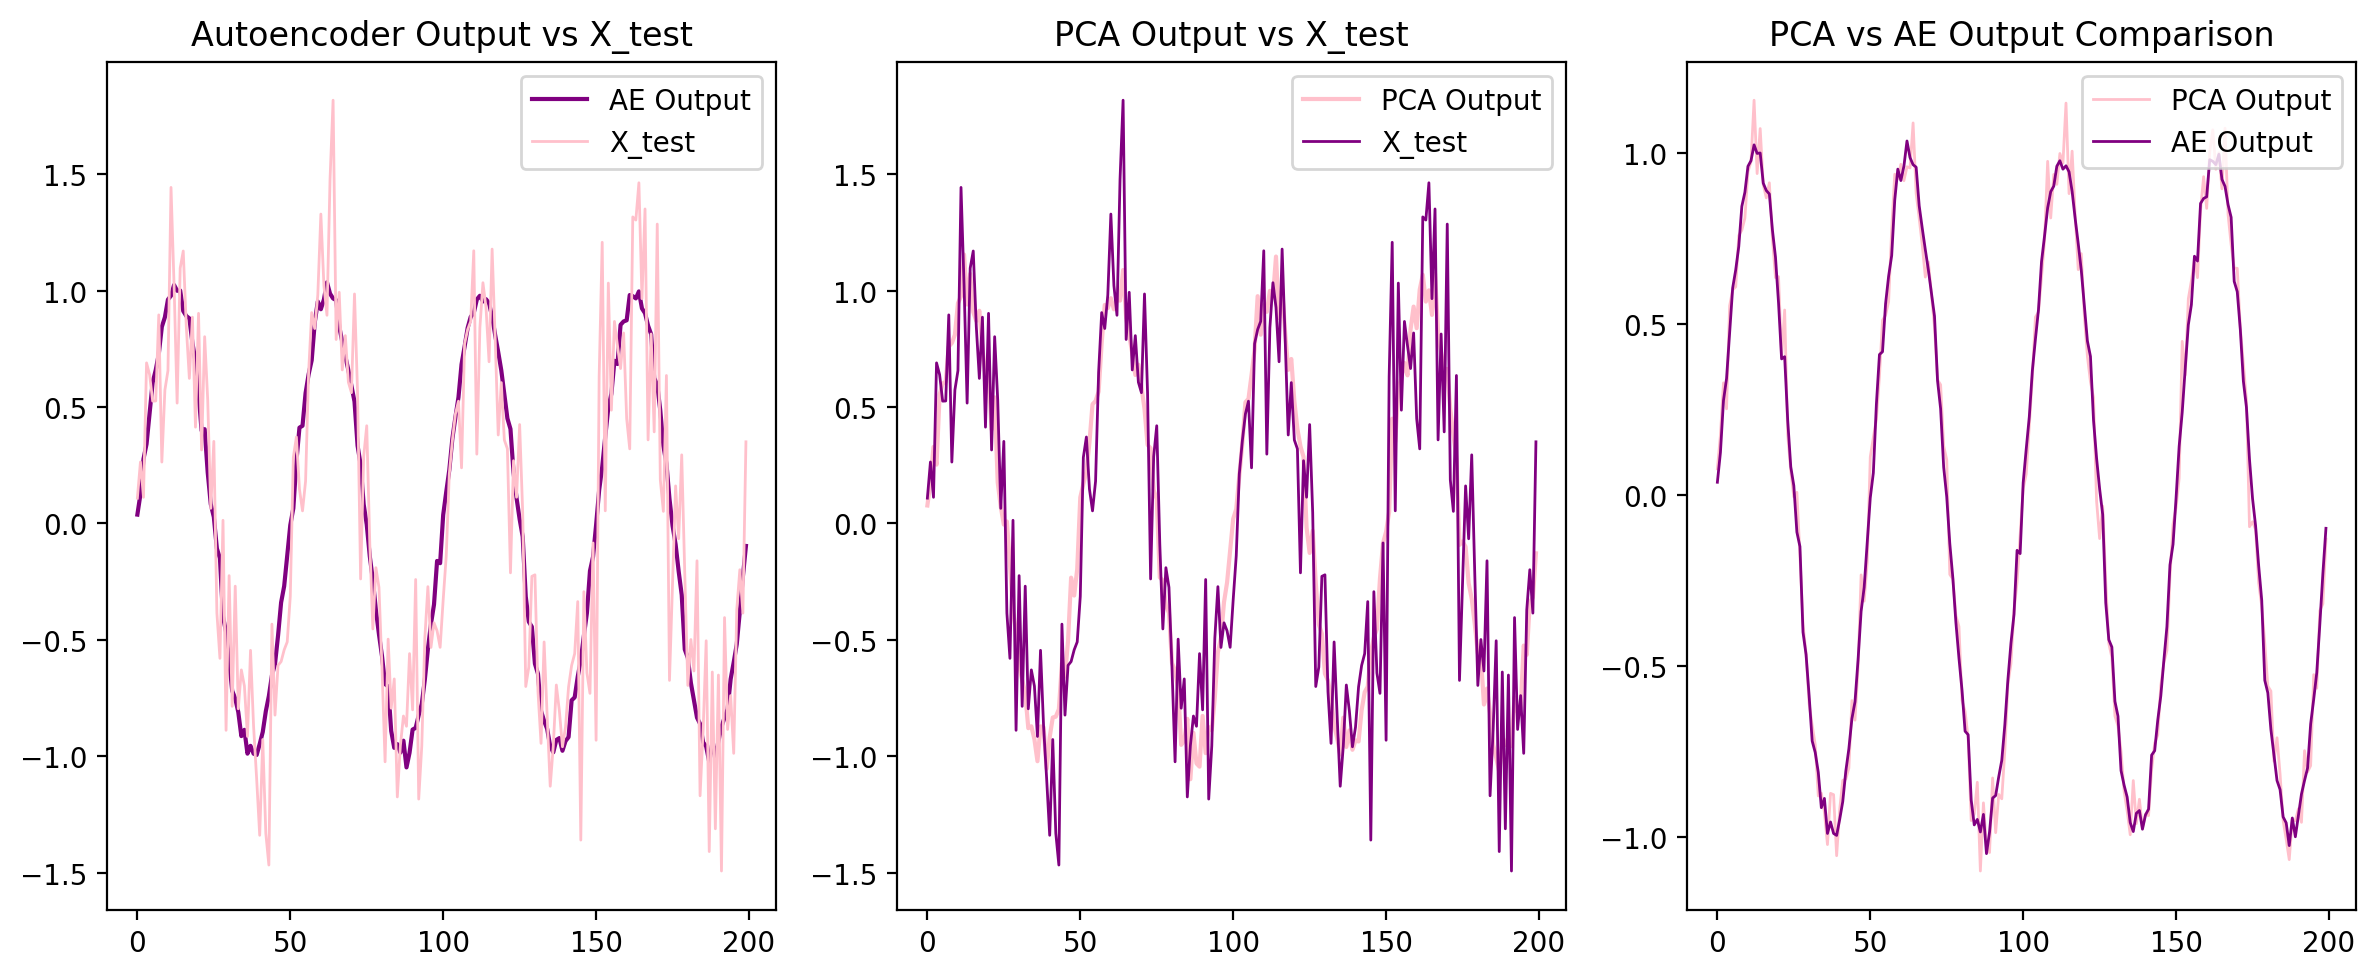

In [22]:
performPCA(3)

Explained Variance:  [0.01694589 0.01669741 0.01656348 0.01590166]
Number of Components: 4


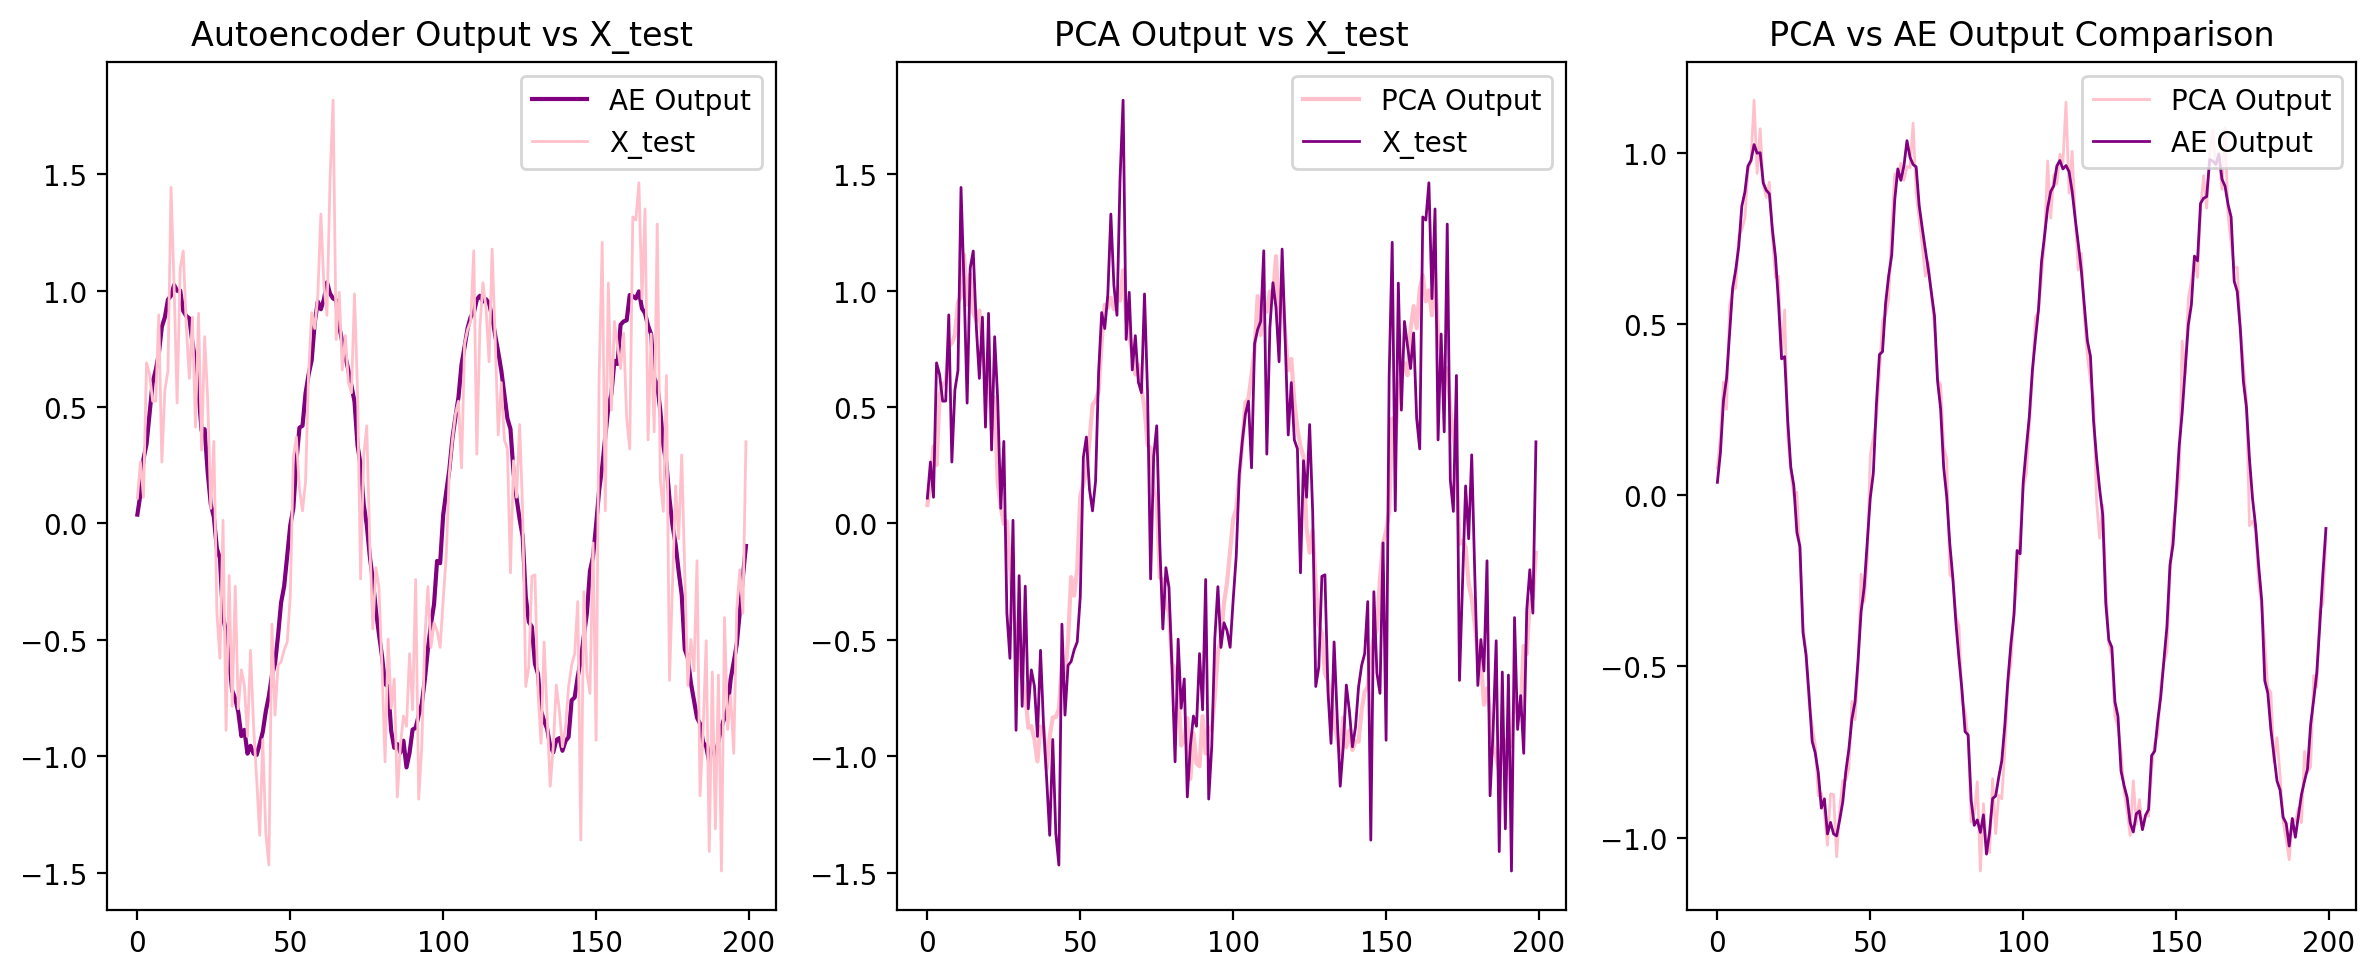

In [23]:
performPCA(4)

##### Question 8 [20 points]

Please record a 2-5 minute video of yourself explaining questions 1 to 7.

If you are shy (or have a bad hairday) you can use filters to augment or cover your face. Please submit it as a public google drive url.

link to the video: https://drive.google.com/file/d/193JhK7-PgFr4LVGPDGkVTb59Qri2oXlB/view?usp=sharing